# Finding the best "hygge" path 🏞️

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data
### Bike paths
To get the bike paths, we use _OpenStreetMap_ with the library `osmnx`. We query OSM with the _Københavns Kommune_ and _Frederiksberg Kommune_ geocodes. We specify `network_type='bike'` to strictly get bike paths. Since the streets are danish, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [2]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


### Bird attributes
Bird data is extracted in the [`bird-edges.ipynb`](/notebooks/bird-edges.ipynb) notebook. Birds are attributed to an edge if a 50m buffer around the bird intersects with a given street.

In [3]:
birds = pd.read_csv('../data/bird_edges.csv').set_index(['u', 'v', 'key'])
birds.head()

birds  birds_per_m
u          v          key                    
118725     298795432  0      8.0     0.070877
           6357644306 0      3.0     0.074080
298795432  298795496  0      7.0     0.077950
6357644306 2378383724 0      2.0     0.091199
           6357644350 0      1.0     0.043373

### Tree attributes
Tree data is extracted in the [`tree-edges.ipynb`](/notebooks/tree-edges.ipynb) notebook. Trees are assigned to the nearest road with a maximum distance of 10m. Each tree is assigned to at most 1 street.

In [4]:
trees = pd.read_csv('../data/tree_edges.csv').set_index(['u', 'v', 'key'])
trees.head()

trees  trees_per_m
u          v          key                    
118725     298795432  0      0.0          0.0
           6357644306 0      0.0          0.0
298795432  298795496  0      0.0          0.0
6357644306 2378383724 0      0.0          0.0
           6357644350 0      0.0          0.0

### Traffic noise attributes
![image.png](../pictures/noise.png)

### Putting it all together
Once all the individual data parts are loaded, they are joined into a single dataframe.

In [5]:
gdf = edges
gdf = gdf.merge(birds, right_index=True, left_index=True, how='left')
gdf = gdf.merge(trees, right_index=True, left_index=True, how='left')
... # noise

Ellipsis

In [6]:
gdf.head()

osmid  oneway              name   highway  \
u          v          key                                                  
118725     298795432  0     27226011    True  Banegårdspladsen  tertiary   
           6357644306 0    140412993    True     Vesterbrogade  tertiary   
298795432  298795496  0    244360867    True  Banegårdspladsen  tertiary   
6357644306 2378383724 0    678991574    True     Vesterbrogade  tertiary   
           6357644350 0    679140293    True     Vesterbrogade  tertiary   

                          maxspeed   length  \
u          v          key                     
118725     298795432  0         30  112.872   
           6357644306 0         50   40.497   
298795432  298795496  0         30   89.801   
6357644306 2378383724 0         50   21.930   
           6357644350 0         50   23.056   

                                                                    geometry  \
u          v          key                                                      
118725     298795432  0    LINESTRING (724025.025 6175551.339, 724031.889...   
           6357644306 0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432  298795496  0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306 2378383724 0    LINESTRING (724059.919 6175572.112, 724075.704...   
           6357644350 0    LINESTRING (724059.919 6175572.112, 724081.508...   

                          lanes bridge  ref service width access tunnel  \
u          v          key                                                 
118725     298795432  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644306 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
298795432  298795496  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
6357644306 2378383724 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644350 0       1    NaN  NaN     NaN   NaN    NaN    NaN   

                          junction  birds  birds_per_m  trees  trees_per_m  
u          v          key                                                   
118725     298795432  0        NaN    8.0     0.070877    0.0          0.0  
           6357644306 0        NaN    3.0     0.074080    0.0          0.0  
298795432  298795496  0        NaN    7.0     0.077950    0.0          0.0  
6357644306 2378383724 0        NaN    2.0     0.091199    0.0          0.0  
           6357644350 0        NaN    1.0     0.043373    0.0          0.0

## Finding the best "hygge" path

In [7]:
features = ['birds_per_m', 'trees_per_m']
for feature in features:
    quant = gdf[feature].quantile(0.9)
    gdf[feature + '_cat'] = gdf[feature].apply(lambda x: x > quant)

features_cat = [feature + '_cat' for feature in features]
gdf['super_hygge'] = gdf[features_cat].all(axis=1)

In [8]:
def assign_label(x):
    if x['super_hygge']:
        return 'super_hygge'
    if x['trees_per_m_cat']:
        return 'tree'
    if x['birds_per_m_cat']:
        return 'bird'
    else:
        return 'lortevej'
         
gdf['hygge_cat'] = gdf.apply(assign_label, axis=1)

In [9]:
hygge_alpha = {
    'super_hygge': 1,
    'bird': 0.3,
    'tree': 0.3,
    'lortevej': 0.2
}

hygge_color = {
    'super_hygge': '#c00',
    'bird': '#060',
    'tree': '#00a',
    'lortevej': 'grey'
}

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


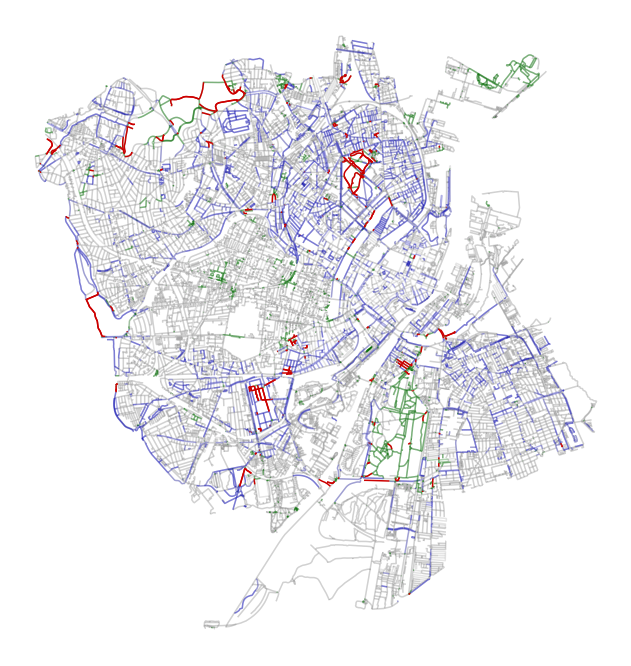

In [10]:
f, ax = plt.subplots(figsize=(12, 12))

for hygge_cat in gdf.hygge_cat.unique():
    gdf[gdf.hygge_cat==hygge_cat].plot(
        column='hygge_cat',
        color=hygge_color[hygge_cat],
        alpha=hygge_alpha[hygge_cat],
        ax=ax)
ax.set_axis_off()